In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


27
243


<Figure size 432x288 with 0 Axes>

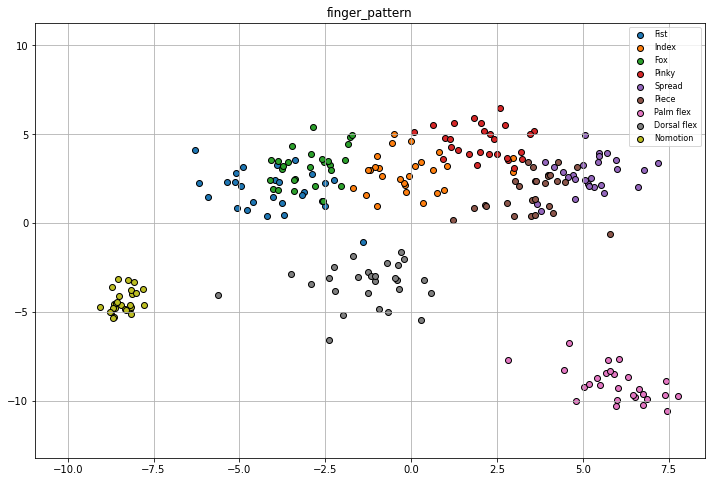

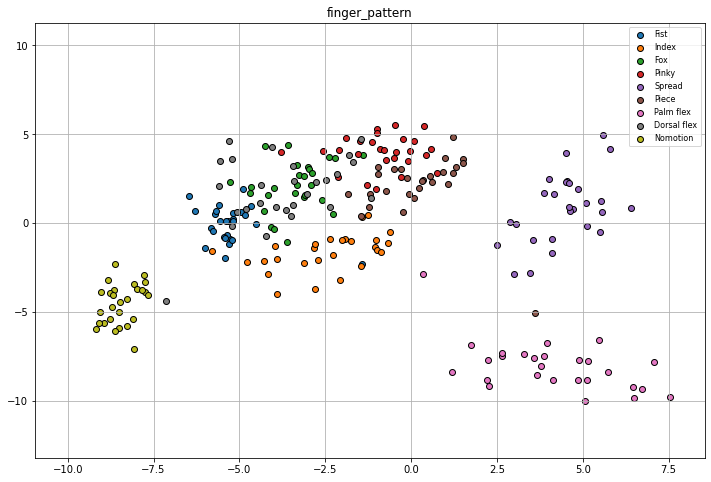

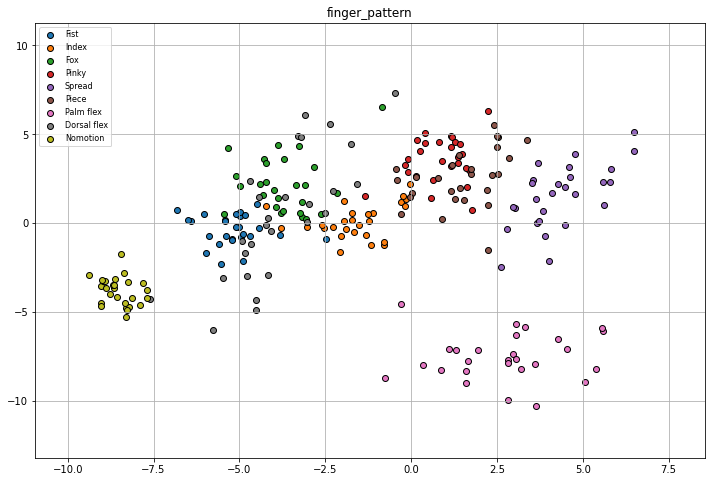

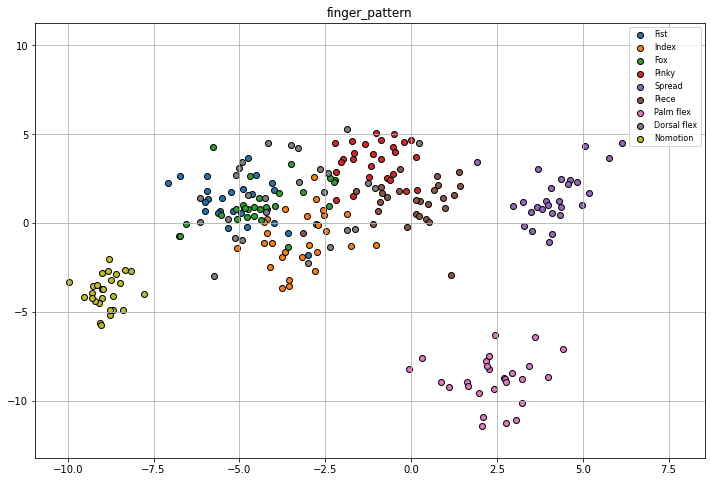

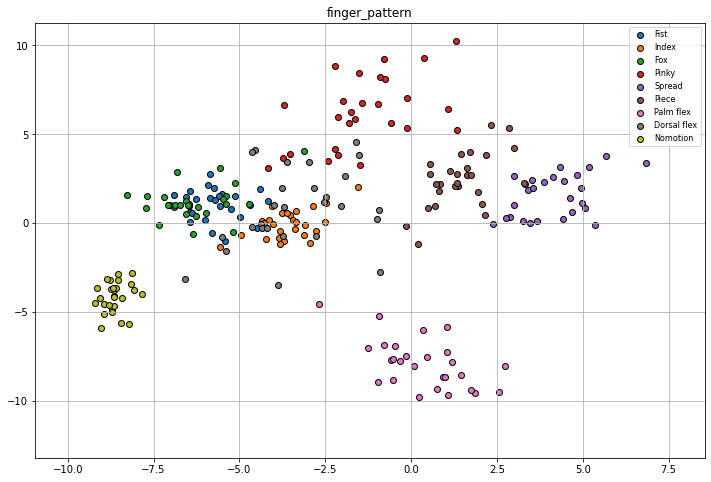

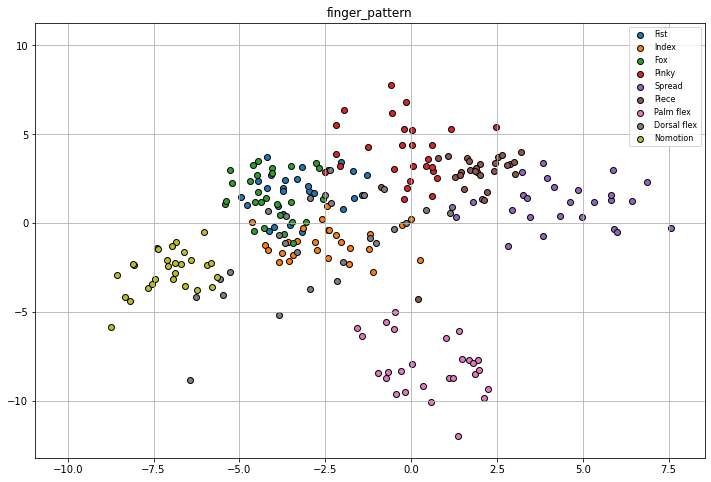

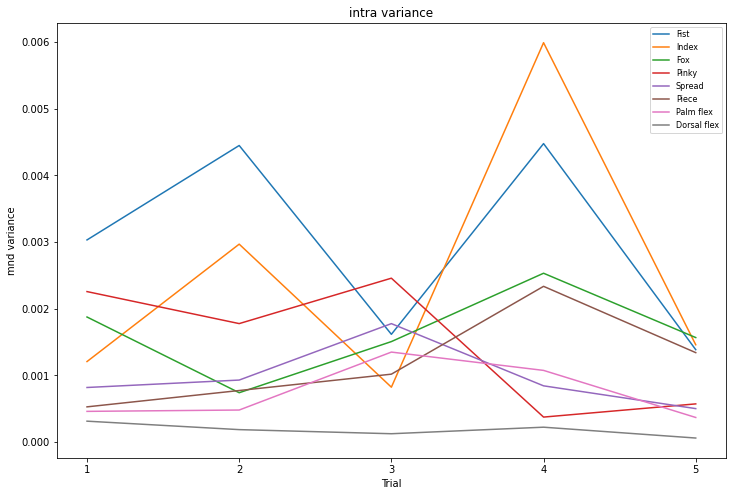

In [56]:
#/content/drive/Shareddrives/近藤研究室/学生/B4/安田/本実験
#@title 被験者・条件設定部(変更時に自動実行){ run: "auto" }
subject3="nkn"  #@param["sgwr","kwmr","frn","tni","tnk","hdk","nkn","ibk"] 
hand3="l"  #@param["r","l"]
filepath3="/content/drive/Shareddrives/近藤研究室/学生/B4/安田/本実験/"+subject3
#各トライアル後の計測金電位のクラスター解析
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial import distance
import random

#条件の全ファイル読み込み
EMG2d_points=[]
EMG2d_features=[]
EMG2d_centers=[]
LDA=LinearDiscriminantAnalysis(n_components=2)
sample_num=[]
#データサンプル数を揃える
for i in range(6):
  tmp_df = pd.read_csv(filepath3+"/"+subject3+"_"+hand3+"_base"+str(i)+".csv", header=0, index_col=0)
  features = tmp_df.values[:,-1]
  tmp_df=tmp_df.values[:,0:-1]
  tmp_samples=[]
  for k in range(9):
    tmp = []
    tmp.append(len([tmp_df[j] for j in range(len(features)) if features[j] == (k)]))
    tmp_samples.append(tmp)
  sample_num.append(tmp_samples)
min_sample=np.nanmin(np.array(sample_num).flatten())
df=[]
for i in range(6):
  tmp_df = pd.read_csv(filepath3+"/"+subject3+"_"+hand3+"_base"+str(i)+".csv", header=0, index_col=0)
  features = tmp_df.values[:,-1]
  tmp_df=tmp_df.values
  tmp_samples=[]
  for k in range(9):
    tmp=[tmp_df[j] for j in range(len(features)) if features[j] == (k)]
    tmp = random.sample(tmp,min_sample)
    tmp_samples.extend(tmp)
  df.append(tmp_samples)
print(min_sample)
print(len(df[0]))

#重心計算とLDA学習
for i in range(6):
  tmp_df = pd.DataFrame(df[i])
  features = tmp_df.values[:,-1]
  tmp_df=tmp_df.values[:,0:-1]
  if(i==0):
    LDA.fit(tmp_df, features)
  EMG2d_points.append(LDA.transform(tmp_df))
  tmp_centers=[] #各クラスの重心
  tmp2d_points=EMG2d_points[i]
  for k in range(9):
      tmp = []
      tmp.append(np.mean([tmp2d_points[j][0] for j in range(len(tmp2d_points)) if features[j] == (k)]))
      tmp.append(np.mean([tmp2d_points[j][1] for j in range(len(tmp2d_points)) if features[j] == (k)]))
      tmp_centers.append(tmp)
  EMG2d_centers.append(tmp_centers)
  EMG2d_features.append(features)

#散布図作成
#_最大、最小値検索
x_cordn=[]
y_cordn=[]
for i in range(6):
  x_cordn.extend(EMG2d_points[i][:,0])
  y_cordn.extend(EMG2d_points[i][:,1])
x_max=max(x_cordn)
x_min=min(x_cordn)
y_max=max(y_cordn)
y_min=min(y_cordn)
#_描画
plt.figure()
for i in range(6):
  fig = plt.figure(figsize=(12, 8))
  ax = plt.subplot(111)
  label_ = ["Fist", "Index","Fox","Pinky","Spread","Piece","Palm flex","Dorsal flex","Nomotion"]
  tmp2d_points=EMG2d_points[i]
  features=EMG2d_features[i]
  for k in range(9):    #手描画
      tmp = []
      tmp.append([tmp2d_points[j][0] for j in range(len(tmp2d_points)) if features[j] == (k)])
      tmp.append([tmp2d_points[j][1] for j in range(len(tmp2d_points)) if features[j] == (k)])
      tmp = np.array(tmp)
      scat_finger=ax.scatter(tmp[0], tmp[1], label=label_[k], cmap='viridis', edgecolor='blacK')
  ax.set_title("finger_pattern")
  ax.legend(labels=label_, fontsize=8)
  ax.set_xlim(x_min*1.1,x_max*1.1)
  ax.set_ylim(y_min*1.1,y_max*1.1)
  plt.grid()
  plt.show()

#クラス内の所属確率の分散、クラス間距離の計算
#https://emoson.hateblo.jp/entry/2015/02/06/182256
#借りました
def mnd(_x, _mu, _sig):
    x = np.matrix(_x)
    mu = np.matrix(_mu)
    sig = np.matrix(_sig)
    a = np.sqrt(np.linalg.det(sig)*(2*np.pi)**sig.ndim)
    b = np.linalg.det(-0.5*(x-mu)*sig.I*(x-mu).T)
    return np.exp(b)/a

intra_var=[]
class_covs=[]
for i in range(6):
  class_=[]
  tmp2d_points=EMG2d_points[i]
  features=EMG2d_features[i]
  tmp_vars=[]
  tmp_covs=[]
  for k in range(9):    
      tmp = []
      tmp.append([tmp2d_points[j][0] for j in range(len(tmp2d_points)) if features[j] == (k)])
      tmp.append([tmp2d_points[j][1] for j in range(len(tmp2d_points)) if features[j] == (k)])
      tmp = np.array(tmp)
      tmp_covs.append(np.cov(tmp[0],tmp[1]))
      tmp_mnds=[]
      for m in range(len(tmp[0])):
        tmp_mnds.append(mnd(tmp[:,m],EMG2d_centers[i][k],tmp_covs[k]))
      tmp_vars.append(np.var(tmp_mnds))
  intra_var.append(tmp_vars)
        
#クラス内分散のグラフ表示
intra_var=np.array(intra_var)
intra_var=intra_var.T
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
label_ = ["Fist", "Index","Fox","Pinky","Spread","Piece","Palm flex","Dorsal flex","Nomotion"]
for i in range(8):
  ax.plot(range(1,6),intra_var[i][1:])
ax.set_title("intra variance")
ax.legend(labels=label_, fontsize=8)
plt.xticks(np.arange(1, 6, step=1))
plt.xlabel("Trial")
plt.ylabel("mnd variance")
plt.show()

  


In [ ]:
#@title 被験者・条件設定部(変更時に自動実行){ run: "auto" }
#被験者・条件毎の重心計算と散布図まで実装
subject1="tnk"  #@param["sgwr","kwmr","frn","tni","tnk","hdk","nkn","ibk"] 
hand1="l"  #@param["r","l"]
filepath1="/content/drive/Shareddrives/近藤研究室/学生/B4/安田/本実験/"+subject1
#評価タスクの秒数計算
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

#ファイル読み込み
task_times=[[] for i in range(9)]
filenum=0
for j in range(6):
  tmp_result = np.loadtxt(filepath1+"/times/"+subject1+"_"+hand1+"_eva"+str(j)+".txt",delimiter=",")
  for i in range(18):
    task_times[int(tmp_result[i+18])].append(tmp_result[i])

#平均を出す(暫定)

#表示
plt.figure()
for j in range(9):
  plt.plot(task_times[j])
  plt.show()

タスク秒数：各タスクで２つずつあるデータはどう扱うか　２こイチで表記するか、平均にするか、時系列に沿って並べるか

タスク中の筋電位データの座標はどう扱うか
９種類のタスク毎にマハラノビス距離or確率変数を計算し、base0のデータに対してどの様な位置を見つけて居るかを確かめる。

In [ ]:
#/content/drive/Shareddrives/近藤研究室/学生/B4/安田/本実験
#@title 被験者・条件設定部(変更時に自動実行){ run: "auto" }
subject2="ibk"  #@param["sgwr","kwmr","frn","tni","tnk","hdk","nkn","ibk"] 
hand2="l"  #@param["r","l"]
filepath2="/content/drive/Shareddrives/近藤研究室/学生/B4/安田/本実験/"+subject2
#base0に対しての評価タスクデータ計算
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial import distance
class_f = 9  # 指
lda_finger=LinearDiscriminantAnalysis(n_components=2)
base_df = pd.read_csv(filepath2+"/"+subject2+"_base0_r.csv", header=0, index_col=0)
features_finger = base_df.values[:,-1]
base_df=base_df.values[:,0:-1]
base2d_finger = lda_finger.fit(base_df, features_finger).transform(base_df)
basedata_finger=[] #各クラスの重心
for k in range(class_f):
    tmp = []
    tmp.append([base2d_finger[j][0] for j in range(len(base2d_finger)) if features_finger[j] == (k)])
    tmp.append([base2d_finger[j][1] for j in range(len(base2d_finger)) if features_finger[j] == (k)])
    basedata_finger.append(tmp)
basedata_f_centers=[]

for i in range(class_f):
    tmp=[]
    tmp.append(np.mean(basedata_finger[i][0]))
    tmp.append(np.mean(basedata_finger[i][1]))
    basedata_f_centers.append(tmp)

#ここからが計測データの処理
basedata_f_cov=[]

for i in range(9):
    tmp=np.cov(basedata_finger[i][0],basedata_finger[i][1])
    basedata_f_cov.append(np.linalg.pinv(tmp))

input_f_maharanobis=[]
input_df = pd.read_csv(filepath2+"/"+subject2+"/"+subject2+"_"+hand2+"_base"+i+"_r.csv", header=0, index_col=0)
input_finger2d=np.array(input_df.values[:,0:3])
input_wrist2d=np.array(input_df.values[:,3:6])

input_f_labels=np.array(input_df.values[:,0])
for j in range(class_f):
    center=basedata_f_centers[j]
    tmp=[]
    for i in range(len(input_finger2d)):
        tmp.append(distance.mahalanobis(list(input_finger2d[i][1:3]),center,basedata_f_cov[int(input_finger2d[i][0])-1]))
    input_f_maharanobis.append(tmp)


fig, axlist = plt.subplots(2,1,figsize=(18.0, 12.0))
id=421
title=["fist","index","fox","pinky","spread","piece","wave in","wave out","nomotion"]
i=0
for ax in axlist:
    ax.set_title(title[i])
    ax.plot(np.arange(len(input_f_maharanobis[0])),input_f_maharanobis[i]) #int(input_finger2d[i][0])-1
    ax.grid()
    ax.set_xlabel('sample')
    ax.set_ylabel('maharanobis distance')
    i+=1
plt.subplots_adjust(wspace=0.4, hspace=1)

target_class=0
pre=9
target_flag=False
part_ave_mahalanobis=[]
part_var_mahalanobis=[]
tmp=[]
tmp1=[]
j=0
for ax in axlist:

    for i in range(len(input_finger2d)):    #len(input_finger2d)-1
        if target_flag:
            tmp.append(input_f_maharanobis[j][i])
            tmp1.append(input_f_maharanobis[j][i])
        if input_finger2d[i][0] != pre:
            if target_flag:
                ax.axvspan(start, i, facecolor='orange', alpha=0.5)
                target_flag=False
                part_ave_mahalanobis.append(round(np.mean(tmp[2:-3]),4))
                part_var_mahalanobis.append(round(np.var(tmp[2:-2]),4))
            if input_finger2d[i][0]==target_class:
                start=i
                target_flag=True
                tmp = []
            pre=input_finger2d[i][0]
    print(part_ave_mahalanobis)
    print(part_var_mahalanobis)
    j+=1
    plt.xlabel('time(1 sample/0.16s)')
    plt.ylabel('maharanobis distance')
    plt.show()
    if j==1 :
        break


fig1, ax1 = plt.subplots()
ax1.set_title('Mahalanobis distance')
ax1.set_xticklabels(['average'])
ax1.boxplot(tmp1)
plt.show()

FileNotFoundError: ignored

データ数が異なるbaseデータサンプルは最小データサンプルのサンプル数に合わせて他のデータサンプルの数も減らし、改めて描画する
座標は2次元,分散の度合いは多変量正規分布の値の分散

変換行列はベースデータのものを使用すること

考察には確率密度の分散と、各クラス間確率密度の合計、トライアル後のデータが